In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline


In [2]:
df = pd.read_csv('./database.sqlite')

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


- CASEID - case number
- DOF1 - direction of force (highest)
- GAD1 - deformation location (highest)
- PSU - primary sampling unit number
- YEAR - calender year of crash
- STRATIF - case stratum
- BODYTYPE - vehicle body type
- DVEST - estimated highest delta V
- DVBASIS - basis for total deltav V (highest)
- DVTOTAL - total delta V
- MAKE - vehicle make
- MODELYR - vehicle model year
- AGE - age of occupant
- BAGAVAIL - air bag system availability
- BAGDEPLY - air bag system deployed
- BAGFAIL - air bag system failure
- CASENO - case sequence number
- CHTYPE - type of child safety seat
- DEATH - time of death
- HEIGHT - height of occupent
- HOPSTAY - hospital stay
- INJSEV - injury severity (police rating)
- MANAVAIL -
- MANFAIL - 
- MANUSE - manual belt system use 
- OCCNO - occupant number
- ROLE - occupant's role
- SEATPOS - occupant's seat position
- SEX - occupant's sex
- TREATMENT - treatment - mortality
- WEIGHT - occupant's weight

In [3]:
fatal = df.copy()

In [4]:
fatal.columns

Index(['Unnamed: 0', 'CASEID', 'DOF1', 'GAD1', 'PSU', 'YEAR', 'STRATIF',
       'BODYTYPE', 'DVEST', 'DVBASIS', 'DVTOTAL', 'MAKE', 'MODELYR', 'AGE',
       'BAGAVAIL', 'BAGDEPLY', 'BAGFAIL', 'CASENO', 'CHTYPE', 'DEATH',
       'HEIGHT', 'HOSPSTAY', 'INJSEV', 'MANAVAIL', 'MANFAIL', 'MANUSE',
       'OCCNO', 'ROLE', 'SEATPOS', 'SEX', 'TREATMNT', 'WEIGHT'],
      dtype='object')

In [5]:
# changing all columns to lower case
columns = fatal.columns
columns_lower = []
for col in columns:
    columns_lower.append(col.lower())
fatal.columns = columns_lower

In [6]:
## removed unnamed: 0 column since it matched the index
fatal.drop(labels='unnamed: 0',axis=1,inplace=True)

In [7]:
# dictionay of categorie ID's (named how they will appear when get dummies is applied)
dvest = {'dvest_0':'reconstructed_dv','dvest_1':'dv<10kmph','dvest_2':'10 >= dv < 25kmph','dvest_3':'25 >= dv < 40kmph',
         'divest_4':'40 >= dv <55kmph','divest_5':'dv >= 55kmph','divest_6':'minor damage','divest_7':'moderat damage',
         'divest_8':'severe damage'}

dvbasis = {'dvbasis_0':'not_ispctd','dvbasis_1':'S_dmg_only','dvbasis_2':'S_dmg_&_trjctry','dvbasis_3':'S_missing_vhcl', 
           'dvbasis_4':'S_dmg_cdc_only', 'dvbasis_5':'one_vhcle_byond_S_scope','dvbasis_6':'rollover',
           'dvbasis_7':'non_hrzntl_forces','dvbasis_8':'sideswipe_dmg','dvbasis_9':'severe_override',
          'dvbasis_10':'ylding_objct','dvbasis_11':'overlapping_dmg','dvbasis_12':'insuf_data',
           'dvbasis_98':'other','dvbasis_99':'unknown'}

gad1 = {'gad1_F':'front','gad1_L':'left','gad_R':'right','gad1_B':'back','gad1_uk':'unkown','gad1_T':'top',
        'gad1_U':'undercarriage'}


bagavail = {'bagavail_1':'no','bagavail_2':'yes','bagavail_3':'unknown'}
# stratif = {'stratif_k':'fatality','stratif_F':'injry_no_tow_hsptl',
#           'stratif_E':'injry_tow','stratif_C':'two_tow_no_hsptl','stratif_D':}
# air bad deployed 
bagdeply = {'bagdeply_0':'no_bag', 'bagdeply_1':'impct_deply','bagdeply_3':'deply_ukdetls',
            'bagdeply_5':'uk_deply','bagdeply_7':'no_deply'}

# air bag failure
bagfail = {'bagfail_0':'no_bag','bagfail_1':'no','bagfail_2':'yes'}

# child seat type
chtype = {'chtype chtype _0':'none','chtype_1':'conv_seat','chtype_2':'frwd_face','chtype_3':'infnt_seat',
          'chtype_4':'boost_seat','chtype_7':'vest','chtype_8':'harness'}

# Injury severity
injsev = {'injsev_0':'no_inj','injsev_1':'pssbl_inj','injsev_2':'n_incptng_inj','injsev_3':'incptng_inj',
          'injsev_4':'killed','injsev_5':'inj_sev_uk','injsev_6':'die_b4_crsh'}

# Drop mannavail since it's same data as manuse
# Manual seatbelt used
manuse = {'manuse_0':'none','manuse_1':'inoperative','manuse_2':'shldr_b','manuse_3':'lap_b',
          'manuse_4':'laphshldr_b','manuse_5':'b_avail_uk','manuse_8':'othr_b_use',
          'manuse_12':'shldr_chld_seat','manuse_13':'lap_chld_seat','manuse_14':'lapshldr_chld_seat',
          'manuse_15':'b_chld_seat_uk','manuse_18':'othrb_chld_seat'}

# Manual seatbelt fail
manfail = {'manfail_0':'nouse','manfail_1':'no_mlfctn',
           'manfail_2':'torn_wbbng','manfail_3':'bckl',
           'manfail_4':'uppr_anchr','manfail_5':'othr_anchr',
           'manavail_6':'retrctr','manavail_7':'combo',
           'manfail_8':'other'}

role = {'role_1':'driver','role_2':'passenger'}

# occupant number mix of occno(11- 19) & posture (1-10)
occno = {'occno_0':'nrml_pstr','occno_1':'kneelng_stndng','occno_2':'lyng_accss_seat',
        'occno_3':'kneelng_stndng_frnt_seat'}



In [8]:
# replace 9 with uk for (unknown per the NASS documents)
fatal['gad1'] = fatal['gad1'].copy().replace('9','uk')

In [9]:
# replace 0 with 1 since they are the same thing according to the NASS documents
fatal['bagavail'] = fatal['bagavail'].copy().replace(0,1,axis=0)

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warnings.warn('the "axis" argument is deprecated '


In [10]:
# removing letter at the end and going to drop caseno and PSU since 
# they "are identical variables across all NASS records"
fatal['caseid'] = fatal['caseid'].apply(lambda x: x[:-1].strip())

In [11]:
# according NASS these columns are same info as caseid
fatal.drop(['psu','caseno'],axis=1,inplace=True)

In [12]:
# remove manavail since manuse gives the same information
fatal.drop('manavail', axis=1, inplace=True)

In [13]:
# remove bagavail since bagdeply has the same information
fatal.drop('bagavail', axis=1, inplace=True)

In [14]:
#  Remove occno > 10 since seatpos is the same information
print('There is',(fatal[ fatal['occno'] >10 ]['year'].value_counts().sum() / len(fatal))*100,'% of the data with irrelavent classification')

There is 0.11632928107399904 % of the data with irrelavent classification


In [15]:
# Dictionary of each column's unique values key = counts, value = feature name
unique_dict = {}
for col in fatal.columns:
    unique_dict[col] =  fatal[col].nunique()

# Features <30 counts
categoricals = []
for key in unique_dict.keys():
    if unique_dict[key] < 30:
        categoricals.append(key)

In [16]:
for col in categoricals:
    print(col)
    print(fatal[col].value_counts())

gad1
F     1372618
L      411350
B      330703
R      319169
uk     100183
T       65536
U        3328
Name: gad1, dtype: int64
year
2004    544672
2006    500428
2005    494713
2007    243975
2008    195223
2009    181650
2010    157642
2011    150124
2012    104230
2014    103450
2013     22257
2015     18063
Name: year, dtype: int64
stratif
K    529817
F    442408
E    385249
C    236676
D    235326
G    230456
B    226083
H    214204
J    156951
A     59252
Name: stratif, dtype: int64
dvest
0.0    1674684
7.0     306520
6.0     131007
8.0      84874
2.0      12325
3.0       5534
1.0       3007
5.0       2872
4.0       1199
Name: dvest, dtype: int64
dvbasis
1.0     1035657
3.0      587972
11.0     301492
0.0      295200
4.0      109304
7.0       66250
5.0       53107
10.0      49190
98.0      40293
6.0       37035
9.0       32346
8.0       17075
2.0        1522
Name: dvbasis, dtype: int64
bagdeply
1.0    801298
7.0    779497
0.0    673300
5.0     32038
3.0     26686
Name: bagdeply, 

In [17]:
fatal['injsev'].value_counts()

0.0    941331
3.0    588483
1.0    582178
2.0    421564
4.0     96423
5.0     36568
6.0        56
Name: injsev, dtype: int64

In [18]:
fatal.isnull().sum()

caseid            0
dof1         299352
gad1         113540
year              0
stratif           5
bodytype       2519
dvest        494405
dvbasis       89984
dvtotal     1091276
make          10659
modelyr       13077
age           56349
bagdeply     403608
bagfail      576251
chtype       284986
death        327097
height       689620
hospstay     394158
injsev        49824
manfail      680669
manuse       495745
occno           165
role            200
seatpos      190062
sex           32035
treatmnt     331950
weight       654910
dtype: int64

In [19]:
# dvtotal has 1,091,276 null values.  From the analysis below, that accounts 35 to 50 % of each year's data
dvtotal_na = pd.DataFrame(fatal[ fatal['dvtotal'].isnull() ]['year'].value_counts()).sort_index(ascending=True)

total = pd.DataFrame(fatal['year'].value_counts()).sort_index(ascending=True)

na_percent = pd.concat([dvtotal_na,total], axis=1)
na_percent.columns = ['NAs','Total']

na_percent['%age'] = na_percent['NAs'] / na_percent['Total']
na_percent.sort_index(ascending=True)

,NAs,Total,%age
2004,190316,544672,0.349414
2005,184505,494713,0.372954
2006,197452,500428,0.394566
2007,104293,243975,0.427474
2008,84793,195223,0.434339
2009,80094,181650,0.440925
2010,69222,157642,0.439109
2011,65682,150124,0.437518
2012,53511,104230,0.513393
2013,9208,22257,0.413713


In [20]:
na_percent['%age'].mean()

0.4207771668888894

In [21]:
# Imputer

## Try Dropping NA

In [22]:
fatal_nona = fatal.copy()

# dropping all Na values ~ 42% of the data
fatal_nona.dropna(axis=0,inplace=True)

In [23]:
# join get_dummies data frame with the original data
fatal_nona = pd.concat([fatal_nona, pd.get_dummies(fatal_nona[['gad1','stratif']])],axis=1)

In [24]:
y = fatal_nona['injsev']
X = fatal_nona.copy().drop(['injsev','gad1','stratif','caseid'], axis=1)

In [25]:
# creating the test train split for multiclass modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    stratify=fatal_nona['injsev'])

In [26]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(838425, 39) (838425,) (209607, 39) (209607,)


In [49]:
fatal_nona.dtypes

caseid        object
dof1         float64
gad1          object
year           int64
stratif       object
bodytype     float64
dvest        float64
dvbasis      float64
dvtotal      float64
make         float64
modelyr      float64
age          float64
bagdeply     float64
bagfail      float64
chtype       float64
death        float64
height       float64
hospstay     float64
injsev       float64
manfail      float64
manuse       float64
occno        float64
role         float64
seatpos      float64
sex          float64
treatmnt     float64
weight       float64
gad1_B         uint8
gad1_F         uint8
gad1_L         uint8
gad1_R         uint8
gad1_T         uint8
gad1_U         uint8
stratif_A      uint8
stratif_B      uint8
stratif_C      uint8
stratif_D      uint8
stratif_E      uint8
stratif_F      uint8
stratif_G      uint8
stratif_H      uint8
stratif_J      uint8
stratif_K      uint8
dtype: object

In [27]:
# Standardizing the train and test data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

In [29]:
dt = DecisionTreeClassifier(min_samples_leaf=10)
s = cross_val_score(dt, X_train_ss, y_train, cv=5, n_jobs=2)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.964 ± 0.001


In [31]:
dt.fit(X_train_ss, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [32]:
confusion_matrix(y_test, dt.predict(X_test_ss))

array([[72810,   734,   348,    67,     0,    65,     0],
       [  919, 45915,   711,   323,     0,   136,     0],
       [  455,   807, 31911,   356,     0,    71,     0],
       [   73,   351,   339, 47574,    10,     9,     0],
       [    2,     2,     2,     5,  3576,     0,     0],
       [   80,   123,    83,    19,     0,  1729,     0],
       [    2,     0,     0,     0,     0,     0,     0]])

In [33]:
y_true = y_test.copy()
y_pred = dt.predict(X_test_ss)

In [34]:
confusion = pd.crosstab(y_true, y_pred)
confusion

col_0,0.0,1.0,2.0,3.0,4.0,5.0
injsev,,,,,,
0.0,72810,734,348,67,0,65
1.0,919,45915,711,323,0,136
2.0,455,807,31911,356,0,71
3.0,73,351,339,47574,10,9
4.0,2,2,2,5,3576,0
5.0,80,123,83,19,0,1729
6.0,2,0,0,0,0,0


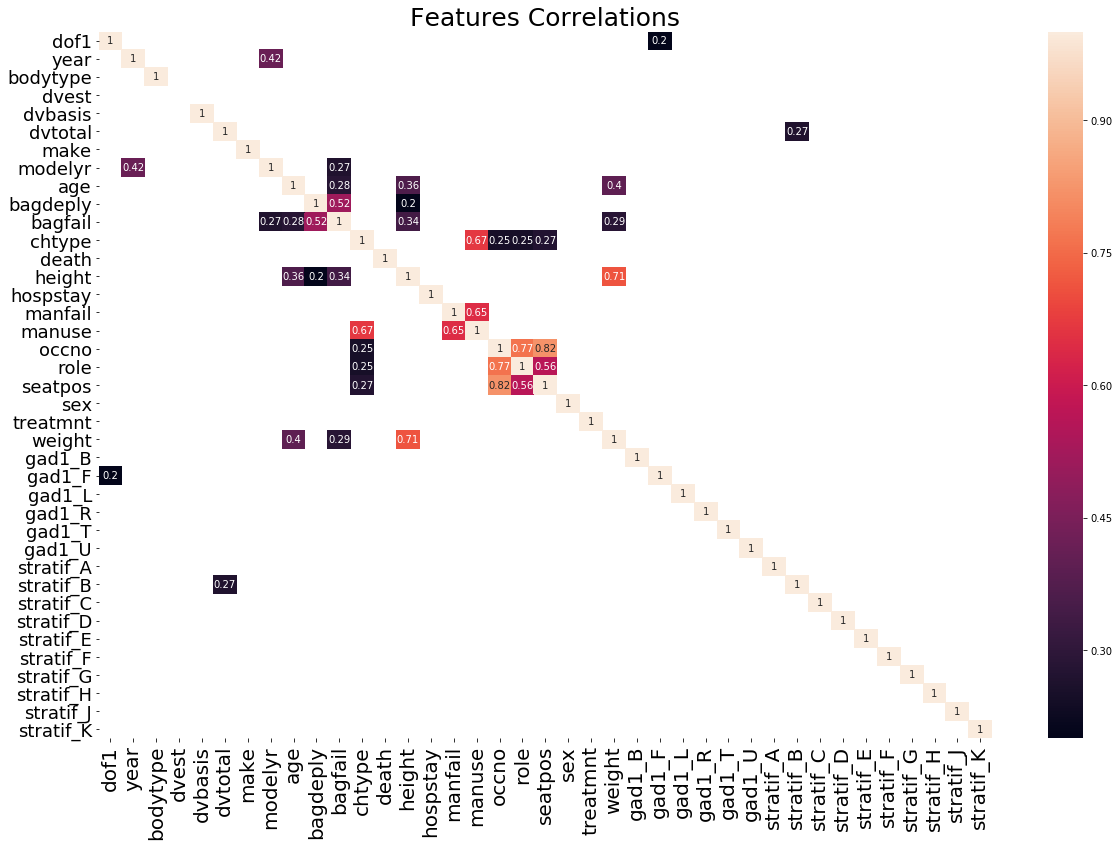

In [52]:
plt.figure(figsize=(20,13))
ax = sns.heatmap(X_train.corr()[X_train.corr()>0.20], annot=True, linecolor='g')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 18)
plt.title('Features Correlations', fontsize = 25)
plt.show()

# df = titanic.pivot_table(index='embark_town', columns='age_group', values='fare', aggfunc=np.median)
# sns.heatmap(df, annot=True, fmt=".1f")
# [X_train.corr()>0.30]

In [ ]:
feature_import = pd.concat([pd.Series(X_train.columns),
                            pd.Series(dt.feature_importances_.tolist())],
                           axis=1).sort_values(1,ascending=False)
feature_import.reset_index(level=0, drop=True, inplace=True)
feature_import.columns = ['feature','importance']

In [ ]:
plt.title('Feature Importances')
plt.barh( feature_import['importance'],color='b', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance') 
plt.show()

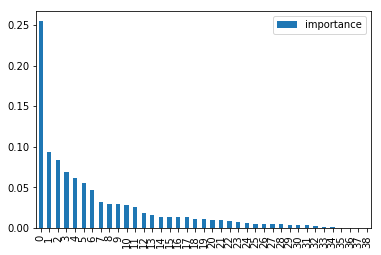

In [113]:
feature_import.plot(kind='bar')

In [ ]:
dt.predict(X_train)

In [ ]:

def build_tree_models(x, y, tree_depth_range=range(1,11), min_leaf):
    tree_model_ypreds = {}
    
    for i in tree_depth_range:
        model = DecisionTreeRegressor(max_depth=i, min_samples_leaf=min_leaf)
        model.fit(x[:, np.newaxis], y)
        tree_model_ypreds[i] = model.predict(x[:, np.newaxis])
        
    return tree_model_ypreds

In [ ]:
def mph(kmph):
    '''
    Function to convert kmph to mph.  
    Enter the speed in kmph and the function converts it to mph.
    - default set to 0.0001
    '''
    return round(0.621371*kmph)